### Seguridad Ecopetrol

## Contenido
* Importación librerías
* Carga información
* Calculo General
* Series de tiempo
 * ITEM
 * DES_ACCION
* Preciciones
* Revisión Metricas
* Seleccion Mejor Método
* Predicciones futuras

## Importación Librerías

In [3]:
import sklearn as sk
print(sk.__version__)

0.24.2


In [1]:
import pandas as pd
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime, date, timedelta
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt,ExponentialSmoothing
import numpy as np
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.filterwarnings('ignore')

## Carga información

In [3]:
path_data = ''
#file= f'VW_TRAF_SEGURIDAD_SEMANA_202109220849.csv'
#file= f'VW_TRAF_SEGURIDAD_SEMANA_202110111532.csv'
file= f'VW_TRAF_SEGURIDAD_SEMANA_202111120957.csv'

df = pd.read_csv(f'{path_data}{file}', sep='|', decimal='.')

In [4]:
df.head()

,FEC_MUESTRA,DES_EVENTO,EQUIPO,DES_EQUIPO,DES_TIPO,DES_ACCION,ITEM,IP,THREAT,VAL_CANTIDAD,VAL_PORCENTAJE
0,2021-11-03 00:00:00,SIN EVENTO,SIN EQUIPO,SIN DES_EQUIPO,facturaelectronica@ecopetrol.com.co,SIN ACCION,SIN ITEN,SIN IP,SIN THREAT,209,0
1,2021-11-03 00:00:00,SIN EVENTO,SIN EQUIPO,SIN DES_EQUIPO,carolina.ramirezba@ecopetrol.com.co,SIN ACCION,SIN ITEN,SIN IP,SIN THREAT,166,0
2,2021-11-03 00:00:00,SIN EVENTO,SIN EQUIPO,SIN DES_EQUIPO,eliana.vega@ecopetrol.com.co,SIN ACCION,SIN ITEN,SIN IP,SIN THREAT,164,0
3,2021-11-03 00:00:00,SIN EVENTO,SIN EQUIPO,SIN DES_EQUIPO,Exchange Policy ATP Escaneo Regular Todos los ...,SIN ACCION,SIN ITEN,SIN IP,SIN THREAT,28235,0
4,2021-11-03 00:00:00,SIN EVENTO,SIN EQUIPO,SIN DES_EQUIPO,Default OneDrive Policy ATP,SIN ACCION,SIN ITEN,SIN IP,SIN THREAT,4197,0


In [5]:
len(df)

1392

##  Cálculo General

In [6]:
dfTotalV2=df.groupby(['FEC_MUESTRA'])[['VAL_CANTIDAD']].agg('sum')
dfTotalV2.index=pd.to_datetime(dfTotalV2.index)

In [7]:
dfTotalV2

,VAL_CANTIDAD
FEC_MUESTRA,
2021-06-30,464957
2021-07-07,420028
2021-07-14,525282
2021-07-21,481735
2021-08-11,984145
2021-08-18,926233
2021-08-25,928288
2021-09-01,888432
2021-09-08,1445879


<AxesSubplot:xlabel='FEC_MUESTRA'>

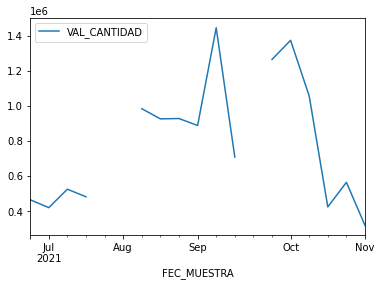

In [8]:
dfTotalV2.asfreq(freq='W-WED').plot()

<AxesSubplot:xlabel='FEC_MUESTRA'>

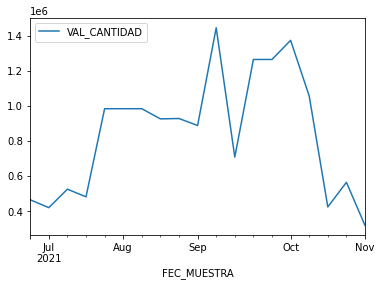

In [9]:
dfTotalV2.asfreq(freq='W-WED',method='bfill').plot()

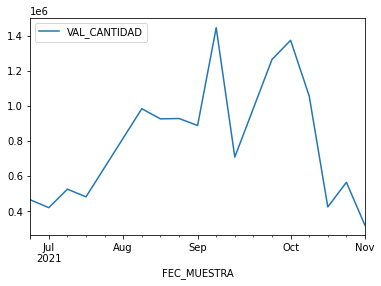

In [10]:
dfTotalV2.asfreq(freq='W-WED').interpolate().plot()
dfTotalV2=dfTotalV2.asfreq(freq='W-WED').interpolate()

### Seleccion Fecha Train y Test

In [11]:
fechaMaxima=max(dfTotalV2.index)
fechaMaxima

Timestamp('2021-11-03 00:00:00', freq='W-WED')

In [12]:
fechaMaxTrain=dfTotalV2.index[-5]
fechaMinTest=dfTotalV2.index[-4]

In [13]:
df_serie_train=dfTotalV2[:fechaMaxTrain]
df_serie_test=dfTotalV2[fechaMinTest:]

In [14]:
df_serie_test

,VAL_CANTIDAD
FEC_MUESTRA,
2021-10-13,1056566.000
2021-10-20,424089.000
2021-10-27,564534.000
2021-11-03,318753.000


In [15]:
ind = pd.date_range(df_serie_test.index.min(), periods = 4, freq ='W-WED', name='FEC_MUESTRA')

In [16]:
modelAutoARIMA=auto_arima(df_serie_train['VAL_CANTIDAD'], max_p = 4, max_q = 4,trace=False)
P_ModeloAUtoArima=pd.DataFrame(modelAutoARIMA.predict(n_periods = 4), index=ind)

In [17]:
dfTotalV2['p_ARIMA']=P_ModeloAUtoArima

In [18]:
## Exponential smooth
modelSM = SimpleExpSmoothing(df_serie_train['VAL_CANTIDAD'])
modelSM._index=df_serie_train.index

In [19]:
#P_ModeloAUtoArima
P_modelSM=modelSM.fit(smoothing_level=.5).forecast(5)
P_modelSM

2021-10-13   1244149.060
2021-10-20   1244149.060
2021-10-27   1244149.060
2021-11-03   1244149.060
2021-11-10   1244149.060
Freq: W-WED, dtype: float64

In [20]:
dfTotalV2['p_ES']=P_modelSM

In [21]:
## Holt

In [22]:
modelHl = Holt(df_serie_train['VAL_CANTIDAD'])
modelHl._index=df_serie_train.index

In [23]:
P_modelHl=modelHl.fit(optimized=True).forecast(5)
P_modelHl

2021-10-13   1335114.862
2021-10-20   1400103.693
2021-10-27   1465092.524
2021-11-03   1530081.355
2021-11-10   1595070.186
Freq: W-WED, dtype: float64

In [24]:
dfTotalV2['p_HL']=P_modelHl

In [25]:
modelESD=ExponentialSmoothing(df_serie_train['VAL_CANTIDAD'], trend='mul', seasonal=None, damped=True)
P_modelESD=modelESD.fit().forecast(5)

In [26]:
P_modelESD

2021-10-13   1382203.553
2021-10-20   1469785.384
2021-10-27   1561956.823
2021-11-03   1658899.109
2021-11-10   1760797.503
Freq: W-WED, dtype: float64

In [27]:
dfTotalV2['p_ESD']=P_modelESD

<AxesSubplot:xlabel='FEC_MUESTRA'>

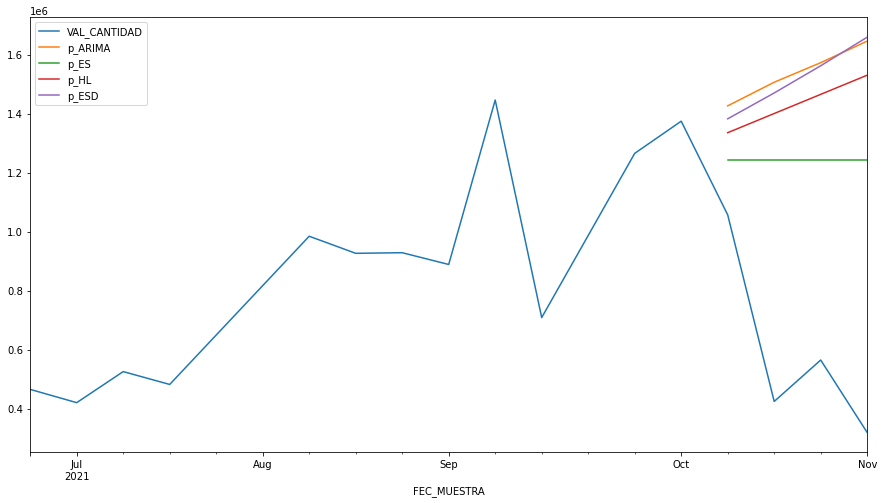

In [28]:
dfTotalV2.reset_index().plot('FEC_MUESTRA',['VAL_CANTIDAD','p_ARIMA','p_ES','p_HL','p_ESD'], figsize=(15,8))

## 2.  Des_Evento

In [29]:
dfDesEvento=df.groupby(['FEC_MUESTRA','DES_EVENTO'])['VAL_CANTIDAD'].agg('sum').reset_index('DES_EVENTO')

In [30]:
dfDesEvento

,DES_EVENTO,VAL_CANTIDAD
FEC_MUESTRA,,
2021-06-30 00:00:00,IPS_FORTINET,29
2021-06-30 00:00:00,SIN EVENTO,342881
2021-06-30 00:00:00,Top 10 Equipos C&c,17635
2021-06-30 00:00:00,Top 10 Equipos Malware,1077
2021-06-30 00:00:00,Top 10 Eventos C&c,101761
...,...,...
2021-11-03 00:00:00,Top 10 Equipos C&c,129982
2021-11-03 00:00:00,Top 10 Equipos Malware,3164
2021-11-03 00:00:00,Top 10 Eventos C&c,7276


In [31]:
## agregar ITEM Malware y DES Accion Bloqueo
df_Accion=df[df['DES_ACCION']=='Bloqueos'].groupby(['FEC_MUESTRA'])[['VAL_CANTIDAD']].agg('sum')
df_Accion.columns=['ACCION_Bloqueos']

In [32]:
df_Accion

,ACCION_Bloqueos
FEC_MUESTRA,
2021-07-07 00:00:00,453
2021-07-14 00:00:00,510
2021-07-21 00:00:00,497
2021-08-11 00:00:00,760
2021-08-18 00:00:00,516
2021-08-25 00:00:00,593
2021-09-01 00:00:00,758
2021-09-08 00:00:00,756
2021-09-15 00:00:00,1022


In [33]:
df_Item=df[df['ITEM']=='Malware'].groupby(['FEC_MUESTRA'])[['VAL_CANTIDAD']].agg('sum')
df_Item.columns=['ITEM_Malware']

In [34]:
df_Item

,ITEM_Malware
FEC_MUESTRA,
2021-06-30 00:00:00,29
2021-07-14 00:00:00,27
2021-07-21 00:00:00,28
2021-08-11 00:00:00,10
2021-08-25 00:00:00,15
2021-09-01 00:00:00,20
2021-09-08 00:00:00,12
2021-09-15 00:00:00,119
2021-09-29 00:00:00,16


In [35]:
dfDesEvento_T=pd.pivot_table(dfDesEvento.reset_index(), index='FEC_MUESTRA', columns='DES_EVENTO', values='VAL_CANTIDAD')

In [36]:
dfDesEvento_T['ACCION_Bloqueos']=df_Accion['ACCION_Bloqueos']
dfDesEvento_T['ITEM_Malware']=df_Item['ITEM_Malware']

In [37]:
dfDesEvento_T

DES_EVENTO,IPS_FORTINET,SIN EVENTO,Top 10 Equipos C&c,Top 10 Equipos Malware,Top 10 Eventos C&c,Top 10 Eventos Malware,Top 10 Eventos Spyware,ACCION_Bloqueos,ITEM_Malware
FEC_MUESTRA,,,,,,,,,
2021-06-30 00:00:00,29.000,342881.000,17635.000,1077.000,101761.000,1461.000,113.000,NaN,29.000
2021-07-07 00:00:00,NaN,293065.000,10705.000,1277.000,113314.000,1583.000,84.000,453.000,NaN
2021-07-14 00:00:00,27.000,352835.000,NaN,477.000,171081.000,758.000,104.000,510.000,27.000
2021-07-21 00:00:00,28.000,323082.000,NaN,245.000,157856.000,459.000,65.000,497.000,28.000
2021-08-11 00:00:00,10.000,804791.000,17738.000,1400.000,158420.000,1749.000,37.000,760.000,10.000
2021-08-18 00:00:00,NaN,757370.000,17927.000,NaN,150511.000,348.000,77.000,516.000,NaN
2021-08-25 00:00:00,15.000,722115.000,27825.000,NaN,176998.000,1162.000,173.000,593.000,15.000
2021-09-01 00:00:00,20.000,719624.000,30467.000,NaN,138210.000,NaN,111.000,758.000,20.000
2021-09-08 00:00:00,12.000,1291229.000,NaN,NaN,153972.000,646.000,20.000,756.000,12.000


In [38]:
dfDesEvento_T.index=pd.to_datetime(dfDesEvento_T.index)

In [39]:
dfDesEvento_T=dfDesEvento_T.asfreq(freq='W-WED').interpolate()
dfDesEvento_T.fillna(method="bfill",inplace=True)

In [40]:
dfDesEvento_T

DES_EVENTO,IPS_FORTINET,SIN EVENTO,Top 10 Equipos C&c,Top 10 Equipos Malware,Top 10 Eventos C&c,Top 10 Eventos Malware,Top 10 Eventos Spyware,ACCION_Bloqueos,ITEM_Malware
FEC_MUESTRA,,,,,,,,,
2021-06-30,29.000,342881.000,17635.000,1077.000,101761.000,1461.000,113.000,453.000,29.000
2021-07-07,28.000,293065.000,10705.000,1277.000,113314.000,1583.000,84.000,453.000,28.000
2021-07-14,27.000,352835.000,12111.600,477.000,171081.000,758.000,104.000,510.000,27.000
2021-07-21,28.000,323082.000,13518.200,245.000,157856.000,459.000,65.000,497.000,28.000
2021-07-28,22.000,483651.667,14924.800,630.000,158044.000,889.000,55.667,584.667,22.000
2021-08-04,16.000,644221.333,16331.400,1015.000,158232.000,1319.000,46.333,672.333,16.000
2021-08-11,10.000,804791.000,17738.000,1400.000,158420.000,1749.000,37.000,760.000,10.000
2021-08-18,12.500,757370.000,17927.000,1513.000,150511.000,348.000,77.000,516.000,12.500
2021-08-25,15.000,722115.000,27825.000,1626.000,176998.000,1162.000,173.000,593.000,15.000


In [41]:
de_serie_train=dfDesEvento_T[:fechaMaxTrain]
de_serie_test=dfDesEvento_T[fechaMinTest:]
grupos=dfDesEvento_T.columns

In [42]:
grupos

Index(['IPS_FORTINET', 'SIN EVENTO', 'Top 10 Equipos C&c',
       'Top 10 Equipos Malware', 'Top 10 Eventos C&c',
       'Top 10 Eventos Malware', 'Top 10 Eventos Spyware', 'ACCION_Bloqueos',
       'ITEM_Malware'],
      dtype='object', name='DES_EVENTO')

In [43]:
de_serie_train

DES_EVENTO,IPS_FORTINET,SIN EVENTO,Top 10 Equipos C&c,Top 10 Equipos Malware,Top 10 Eventos C&c,Top 10 Eventos Malware,Top 10 Eventos Spyware,ACCION_Bloqueos,ITEM_Malware
FEC_MUESTRA,,,,,,,,,
2021-06-30,29.000,342881.000,17635.000,1077.000,101761.000,1461.000,113.000,453.000,29.000
2021-07-07,28.000,293065.000,10705.000,1277.000,113314.000,1583.000,84.000,453.000,28.000
2021-07-14,27.000,352835.000,12111.600,477.000,171081.000,758.000,104.000,510.000,27.000
2021-07-21,28.000,323082.000,13518.200,245.000,157856.000,459.000,65.000,497.000,28.000
2021-07-28,22.000,483651.667,14924.800,630.000,158044.000,889.000,55.667,584.667,22.000
2021-08-04,16.000,644221.333,16331.400,1015.000,158232.000,1319.000,46.333,672.333,16.000
2021-08-11,10.000,804791.000,17738.000,1400.000,158420.000,1749.000,37.000,760.000,10.000
2021-08-18,12.500,757370.000,17927.000,1513.000,150511.000,348.000,77.000,516.000,12.500
2021-08-25,15.000,722115.000,27825.000,1626.000,176998.000,1162.000,173.000,593.000,15.000


In [44]:
prefix=['P_ARIMA_','p_ES_','p_HL_','p_ESD_','p_ETS_']

In [46]:
M_error={}
for col in grupos: 
    M={}
    #model AutoARIMA
    modelAutoARIMA=auto_arima(de_serie_train[col],trace=False)
    modelAutoARIMA.fit(de_serie_train[col])
    P_ModeloAUtoArima=pd.DataFrame(modelAutoARIMA.predict(n_periods = 4), index=ind)
    dfDesEvento_T['P_ARIMA_'+col]=P_ModeloAUtoArima
    # model Exponential Smooting
    modelSM = SimpleExpSmoothing(de_serie_train[col])
    #modelSM._index=df_serie_train.index
    P_modelSM=modelSM.fit(smoothing_level=.5).forecast(4)
    dfDesEvento_T['p_ES_'+col]=P_modelSM
    #Holt
    modelHl = Holt(de_serie_train[col])
    P_modelHl=modelHl.fit(optimized=True).forecast(4)    
    dfDesEvento_T['p_HL_'+col]=P_modelHl
    #ES tend
    modelESD=ExponentialSmoothing(de_serie_train[col], trend='mul', seasonal=None, damped=True)
    P_modelESD=modelESD.fit().forecast(4)
    dfDesEvento_T['p_ESD_'+col]=P_modelESD    
    ##ETS
    modelETS = ETSModel(de_serie_train[col],seasonal_periods=4,error="add",trend="add",seasonal="add", damped_trend=True,)
    modelETS = modelETS.fit()
    start=len(de_serie_train[col])
    P_modelETS=modelETS.get_prediction(start=start, end=start+3).summary_frame(alpha=0.05)['mean']
    dfDesEvento_T['p_ETS_'+col] = P_modelETS
                
    ## calculo de errores
    M['RMSE_ARIMA']=mean_squared_error(de_serie_test[col],P_ModeloAUtoArima, squared=False)
    M['MAPE_ARIMA']=mean_absolute_percentage_error(de_serie_test[col],P_ModeloAUtoArima)
    M['RMSE_ES']=mean_squared_error(de_serie_test[col],P_modelSM, squared=False)
    M['MAPE_ES']=mean_absolute_percentage_error(de_serie_test[col],P_modelSM)
    M['RMSE_HL']=mean_squared_error(de_serie_test[col],P_modelHl, squared=False)
    M['MAPE_HL']=mean_absolute_percentage_error(de_serie_test[col],P_modelHl)
    M['RMSE_ESD']=mean_squared_error(de_serie_test[col],P_modelESD, squared=False)
    M['MAPE_ESD']=mean_absolute_percentage_error(de_serie_test[col],P_modelESD)
    M['RMSE_ETS']=mean_squared_error(de_serie_test[col],P_modelETS, squared=False)
    M['MAPE_ETS']=mean_absolute_percentage_error(de_serie_test[col],P_modelETS)
    
    
    M_error[col]=M

In [47]:
dfDesEvento_T

DES_EVENTO,IPS_FORTINET,SIN EVENTO,Top 10 Equipos C&c,Top 10 Equipos Malware,Top 10 Eventos C&c,Top 10 Eventos Malware,Top 10 Eventos Spyware,ACCION_Bloqueos,ITEM_Malware,P_ARIMA_IPS_FORTINET,...,P_ARIMA_ACCION_Bloqueos,p_ES_ACCION_Bloqueos,p_HL_ACCION_Bloqueos,p_ESD_ACCION_Bloqueos,p_ETS_ACCION_Bloqueos,P_ARIMA_ITEM_Malware,p_ES_ITEM_Malware,p_HL_ITEM_Malware,p_ESD_ITEM_Malware,p_ETS_ITEM_Malware
FEC_MUESTRA,,,,,,,,,,,,,,,,,,,,,
2021-06-30,29.000,342881.000,17635.000,1077.000,101761.000,1461.000,113.000,453.000,29.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-07,28.000,293065.000,10705.000,1277.000,113314.000,1583.000,84.000,453.000,28.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-14,27.000,352835.000,12111.600,477.000,171081.000,758.000,104.000,510.000,27.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-21,28.000,323082.000,13518.200,245.000,157856.000,459.000,65.000,497.000,28.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-28,22.000,483651.667,14924.800,630.000,158044.000,889.000,55.667,584.667,22.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-04,16.000,644221.333,16331.400,1015.000,158232.000,1319.000,46.333,672.333,16.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-11,10.000,804791.000,17738.000,1400.000,158420.000,1749.000,37.000,760.000,10.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-18,12.500,757370.000,17927.000,1513.000,150511.000,348.000,77.000,516.000,12.500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-25,15.000,722115.000,27825.000,1626.000,176998.000,1162.000,173.000,593.000,15.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
M_error

{'IPS_FORTINET': {'RMSE_ARIMA': 10.28936883929773,
  'MAPE_ARIMA': 0.22524038461538465,
  'RMSE_ES': 11.398029277905003,
  'MAPE_ES': 0.15197108038642898,
  'RMSE_HL': 14.40105614105112,
  'MAPE_HL': 0.5251307919124034,
  'RMSE_ESD': 19.161721204182793,
  'MAPE_ESD': 0.6825665640166461,
  'RMSE_ETS': 19.73277655885512,
  'MAPE_ETS': 0.510245741164387},
 'SIN EVENTO': {'RMSE_ARIMA': 899740.9841748282,
  'MAPE_ARIMA': 4.7271460098873375,
  'RMSE_ES': 654777.1803932724,
  'MAPE_ES': 3.445916235509446,
  'RMSE_HL': 660483.0779002651,
  'MAPE_HL': 3.4650067513389486,
  'RMSE_ESD': 778635.7752184066,
  'MAPE_ESD': 4.096914390378109,
  'RMSE_ETS': 755814.9973120822,
  'MAPE_ETS': 3.9338000465315295},
 'Top 10 Equipos C&c': {'RMSE_ARIMA': 97257.7528518301,
  'MAPE_ARIMA': 0.4063544492989789,
  'RMSE_ES': 128745.69964556911,
  'MAPE_ES': 0.6568809489545103,
  'RMSE_HL': 101951.83545490031,
  'MAPE_HL': 0.4433589033589729,
  'RMSE_ESD': 101672.51793931596,
  'MAPE_ESD': 0.42886451282298377,
  'R

In [49]:
df_error=pd.DataFrame.from_dict(M_error, orient='index')
df_error

,RMSE_ARIMA,MAPE_ARIMA,RMSE_ES,MAPE_ES,RMSE_HL,MAPE_HL,RMSE_ESD,MAPE_ESD,RMSE_ETS,MAPE_ETS
IPS_FORTINET,10.289,0.225,11.398,0.152,14.401,0.525,19.162,0.683,19.733,0.510
SIN EVENTO,899740.984,4.727,654777.180,3.446,660483.078,3.465,778635.775,4.097,755814.997,3.934
Top 10 Equipos C&c,97257.753,0.406,128745.700,0.657,101951.835,0.443,101672.518,0.429,132511.603,0.680
Top 10 Equipos Malware,1235.401,0.587,1321.058,0.634,2525.628,1.149,2168.059,0.974,1890.276,0.784
Top 10 Eventos C&c,267278.057,10.328,299612.702,21.652,287520.467,18.756,356038.018,26.540,310389.641,14.984
Top 10 Eventos Malware,1269.223,0.592,1366.385,0.581,1258.939,0.591,1194.946,0.591,1211.397,0.352
Top 10 Eventos Spyware,69.608,4.140,49.802,3.091,97.234,6.003,55.542,3.222,28.052,1.598
ACCION_Bloqueos,314.233,0.490,270.896,0.415,411.347,0.651,457.207,0.724,357.838,0.565
ITEM_Malware,10.289,0.225,11.398,0.152,14.401,0.525,19.162,0.683,19.733,0.510


In [50]:
df_error=df_error[df_error.columns.sort_values()]

In [51]:
df_error

,MAPE_ARIMA,MAPE_ES,MAPE_ESD,MAPE_ETS,MAPE_HL,RMSE_ARIMA,RMSE_ES,RMSE_ESD,RMSE_ETS,RMSE_HL
IPS_FORTINET,0.225,0.152,0.683,0.510,0.525,10.289,11.398,19.162,19.733,14.401
SIN EVENTO,4.727,3.446,4.097,3.934,3.465,899740.984,654777.180,778635.775,755814.997,660483.078
Top 10 Equipos C&c,0.406,0.657,0.429,0.680,0.443,97257.753,128745.700,101672.518,132511.603,101951.835
Top 10 Equipos Malware,0.587,0.634,0.974,0.784,1.149,1235.401,1321.058,2168.059,1890.276,2525.628
Top 10 Eventos C&c,10.328,21.652,26.540,14.984,18.756,267278.057,299612.702,356038.018,310389.641,287520.467
Top 10 Eventos Malware,0.592,0.581,0.591,0.352,0.591,1269.223,1366.385,1194.946,1211.397,1258.939
Top 10 Eventos Spyware,4.140,3.091,3.222,1.598,6.003,69.608,49.802,55.542,28.052,97.234
ACCION_Bloqueos,0.490,0.415,0.724,0.565,0.651,314.233,270.896,457.207,357.838,411.347
ITEM_Malware,0.225,0.152,0.683,0.510,0.525,10.289,11.398,19.162,19.733,14.401


##  Seleccionar modelo por serie

In [52]:
colError=df_error.filter(regex='^MAPE',axis=1).columns.values

In [53]:
colMetodos={x.replace('MAPE_','') for x in colError}

In [54]:
colMetodos

{'ARIMA', 'ES', 'ESD', 'ETS', 'HL'}

In [55]:
minError=list(df_error.filter(regex='^MAPE',axis=1).min(axis=1).values)

In [56]:
minError

[0.15197108038642898,
 3.445916235509446,
 0.4063544492989789,
 0.5872488654759056,
 10.32823092253566,
 0.35236287035643865,
 1.5977559802865473,
 0.41544061751886474,
 0.15197108038642898]

In [57]:
modeloSeleccionado=[np.nan]*len(df_error)
i=0
for ind,row in df_error.filter(regex='^MAPE',axis=1).iterrows():
    auxRow=list(row.values)
    auxInd=auxRow.index(minError[i])
    modeloSeleccionado[i]=colError[auxInd].replace('MAPE_','')
    print(auxRow)
    i=i+1

[0.22524038461538465, 0.15197108038642898, 0.6825665640166461, 0.510245741164387, 0.5251307919124034]
[4.7271460098873375, 3.445916235509446, 4.096914390378109, 3.9338000465315295, 3.4650067513389486]
[0.4063544492989789, 0.6568809489545103, 0.42886451282298377, 0.6796733977702785, 0.4433589033589729]
[0.5872488654759056, 0.6343967018389569, 0.9743336911906444, 0.7841893307480006, 1.1491111190075463]
[10.32823092253566, 21.651876660678823, 26.539987673536018, 14.984207849572417, 18.75551857122633]
[0.5924701733586302, 0.5805861071218473, 0.5911662793180927, 0.35236287035643865, 0.5908365710937343]
[4.140489487404278, 3.090690345215047, 3.221874962340062, 1.5977559802865473, 6.003488131842035]
[0.48998568877966614, 0.41544061751886474, 0.7237095929037157, 0.5648995003348443, 0.651115069987072]
[0.22524038461538465, 0.15197108038642898, 0.6825665640166461, 0.510245741164387, 0.5251307919124034]


In [58]:
modeloSeleccionado

['ES', 'ES', 'ARIMA', 'ARIMA', 'ARIMA', 'ETS', 'ETS', 'ES', 'ES']

In [59]:
df_error['seleccion']=modeloSeleccionado

In [60]:
df_error

,MAPE_ARIMA,MAPE_ES,MAPE_ESD,MAPE_ETS,MAPE_HL,RMSE_ARIMA,RMSE_ES,RMSE_ESD,RMSE_ETS,RMSE_HL,seleccion
IPS_FORTINET,0.225,0.152,0.683,0.510,0.525,10.289,11.398,19.162,19.733,14.401,ES
SIN EVENTO,4.727,3.446,4.097,3.934,3.465,899740.984,654777.180,778635.775,755814.997,660483.078,ES
Top 10 Equipos C&c,0.406,0.657,0.429,0.680,0.443,97257.753,128745.700,101672.518,132511.603,101951.835,ARIMA
Top 10 Equipos Malware,0.587,0.634,0.974,0.784,1.149,1235.401,1321.058,2168.059,1890.276,2525.628,ARIMA
Top 10 Eventos C&c,10.328,21.652,26.540,14.984,18.756,267278.057,299612.702,356038.018,310389.641,287520.467,ARIMA
Top 10 Eventos Malware,0.592,0.581,0.591,0.352,0.591,1269.223,1366.385,1194.946,1211.397,1258.939,ETS
Top 10 Eventos Spyware,4.140,3.091,3.222,1.598,6.003,69.608,49.802,55.542,28.052,97.234,ETS
ACCION_Bloqueos,0.490,0.415,0.724,0.565,0.651,314.233,270.896,457.207,357.838,411.347,ES
ITEM_Malware,0.225,0.152,0.683,0.510,0.525,10.289,11.398,19.162,19.733,14.401,ES


### Visual resultados

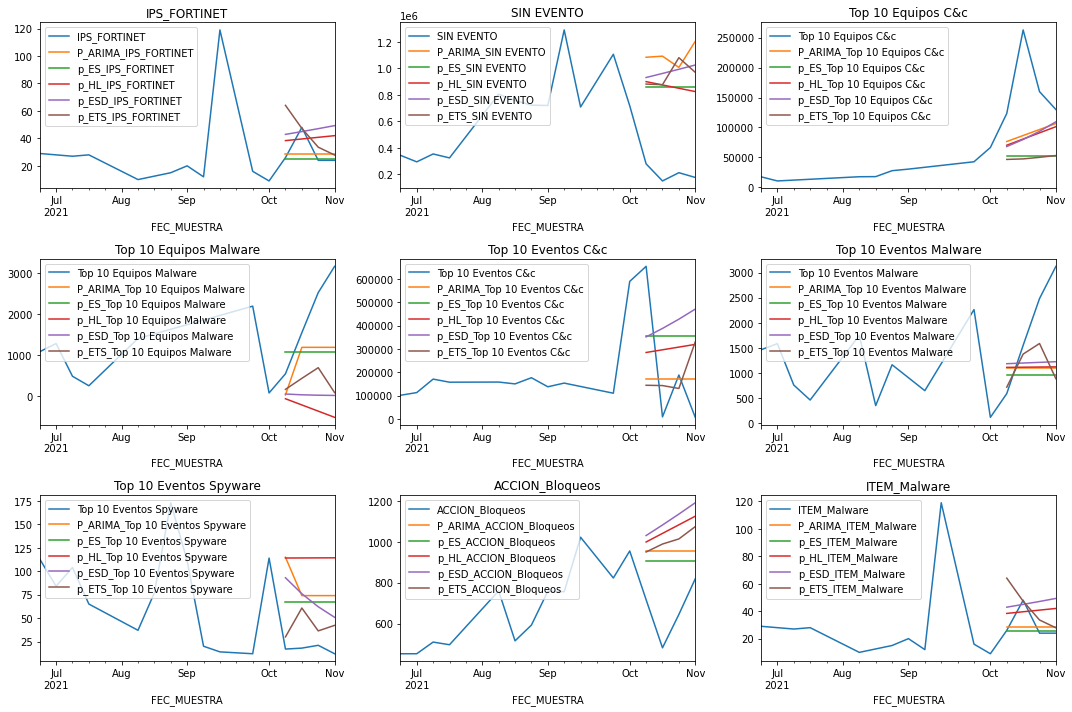

In [61]:
fig, axs = plt.subplots(3, 3 ,figsize=(15,10))
i=0
for col in grupos:
    dfDesEvento_T[[col]].plot(ax=axs[i//3,i%3])    
    axs[i//3,i%3].title.set_text(col)
    for model in prefix:
        dfDesEvento_T[[model+col]].plot(ax=axs[i//3,i%3])
    axs[i//3,i%3].legend(prop={'size':10})
    i=i+1
fig.tight_layout()

### Entrega de resultados

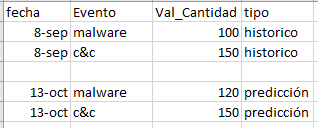

##  Pronosticos futuros

In [62]:
ind_P = pd.date_range(fechaMaxima, periods = 5, freq ='W-WED', name='FEC_MUESTRA')[1:]

In [63]:
ind_P

DatetimeIndex(['2021-11-10', '2021-11-17', '2021-11-24', '2021-12-01'], dtype='datetime64[ns]', name='FEC_MUESTRA', freq='W-WED')

In [64]:
dfResultado=pd.DataFrame(columns=colMetodos, index=ind_P)

In [65]:
dfResultado['SERIE']=np.nan

In [66]:
#dfResultado=dfResultado.reset_index()

In [67]:
dfResultado

,ESD,ES,HL,ETS,ARIMA,SERIE
FEC_MUESTRA,,,,,,
2021-11-10,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-17,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-24,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
dfResultadoFinal=dfResultado.copy()
for col in grupos:     
    #model AutoARIMA
    modelAutoARIMA=auto_arima(dfDesEvento_T[col],trace=False)
    modelAutoARIMA.fit(dfDesEvento_T[col])
    tf=pd.DataFrame(modelAutoARIMA.predict(n_periods = 4), index=ind_P, columns=['ARIMA'])
    modelSM = SimpleExpSmoothing(dfDesEvento_T[col])    
    P_modelSM=modelSM.fit(smoothing_level=.5).forecast(4)
    tf['ES']=P_modelSM
    #Holt
    modelHl = Holt(dfDesEvento_T[col])
    P_modelHl=modelHl.fit(optimized=True).forecast(4)    
    tf['HL']=P_modelHl    
    #ES tend
    modelESD=ExponentialSmoothing(dfDesEvento_T[col], trend='mul', seasonal=None, damped=True)
    P_modelESD=modelESD.fit().forecast(4)
    tf['ESD']=P_modelESD 
    #ETS
    modelETS = ETSModel(dfDesEvento_T[col],seasonal_periods=4,error="add",trend="add",seasonal="add", damped_trend=True,)
    modelETS = modelETS.fit()
    start=len(dfDesEvento_T[col])
    P_modelETS=modelETS.get_prediction(start=start, end=start+3).summary_frame(alpha=0.05)['mean']
    tf['ETS']=P_modelETS 
    #dfDesEvento_T['p_ETS_'+col] = P_modelETS
    
    #serie
    tf['SERIE']=col
    dfResultadoFinal=dfResultadoFinal.append(tf)
    

In [70]:
dfResultadoFinal=dfResultadoFinal[dfResultadoFinal['SERIE'].notnull()]

In [71]:
dfResultadoFinal.reset_index(inplace=True)

In [72]:
dfResultadoFinal

,FEC_MUESTRA,ESD,ES,HL,ETS,ARIMA,SERIE
0,2021-11-10,72.203,27.205,35.690,54.221,29.105,IPS_FORTINET
1,2021-11-17,73.935,27.205,36.348,45.875,29.105,IPS_FORTINET
2,2021-11-24,75.568,27.205,37.007,30.180,29.105,IPS_FORTINET
3,2021-12-01,77.105,27.205,37.665,25.406,29.105,IPS_FORTINET
4,2021-11-10,156065.524,229812.742,119748.076,-133349.608,295542.263,SIN EVENTO
5,2021-11-17,138773.304,229812.742,70009.257,-153233.273,374950.145,SIN EVENTO
6,2021-11-24,123542.075,229812.742,20270.439,-32820.185,427334.837,SIN EVENTO
7,2021-12-01,110110.508,229812.742,-29468.380,-51470.976,461892.566,SIN EVENTO
8,2021-11-10,111350.860,148858.181,128732.396,144558.002,129982.000,Top 10 Equipos C&c
9,2021-11-17,95511.823,148858.181,126588.350,160818.273,129982.000,Top 10 Equipos C&c


In [91]:
# seleccionar mejor resultado
dfResultadoFinal['VAL_CANTIDAD']=0
dfResultadoFinal['metodo']=np.nan
for ind,row in dfResultadoFinal.iterrows():
    #print(ind)
    met=df_error.loc[row['SERIE'],'seleccion']
    #print(met)
    dfResultadoFinal.loc[ind,'metodo']=met
    dfResultadoFinal.loc[ind,'VAL_CANTIDAD']=dfResultadoFinal.loc[ind,met]
    #dfResultadoFinal

In [92]:
#Eliminar predicciones negativas
dfResultadoFinal['VAL_CANTIDAD']=np.where(dfResultadoFinal['VAL_CANTIDAD']<0,0,dfResultadoFinal['VAL_CANTIDAD'])

In [94]:
dfResultadoFinal

,FEC_MUESTRA,ESD,ES,HL,ETS,ARIMA,SERIE,VAL_CANTIDAD,metodo
0,2021-11-10,72.203,27.205,35.690,54.221,29.105,IPS_FORTINET,27.210,ES
1,2021-11-17,73.935,27.205,36.348,45.875,29.105,IPS_FORTINET,27.210,ES
2,2021-11-24,75.568,27.205,37.007,30.180,29.105,IPS_FORTINET,27.210,ES
3,2021-12-01,77.105,27.205,37.665,25.406,29.105,IPS_FORTINET,27.210,ES
4,2021-11-10,156065.524,229812.742,119748.076,-133349.608,295542.263,SIN EVENTO,229812.740,ES
5,2021-11-17,138773.304,229812.742,70009.257,-153233.273,374950.145,SIN EVENTO,229812.740,ES
6,2021-11-24,123542.075,229812.742,20270.439,-32820.185,427334.837,SIN EVENTO,229812.740,ES
7,2021-12-01,110110.508,229812.742,-29468.380,-51470.976,461892.566,SIN EVENTO,229812.740,ES
8,2021-11-10,111350.860,148858.181,128732.396,144558.002,129982.000,Top 10 Equipos C&c,129982.000,ARIMA
9,2021-11-17,95511.823,148858.181,126588.350,160818.273,129982.000,Top 10 Equipos C&c,129982.000,ARIMA


In [95]:
formato_envio_pred=dfResultadoFinal[['FEC_MUESTRA','SERIE','VAL_CANTIDAD']]
formato_envio_pred['tipo']='pred'

In [96]:
formato_envio_pred

,FEC_MUESTRA,SERIE,VAL_CANTIDAD,tipo
0,2021-11-10,IPS_FORTINET,27.210,pred
1,2021-11-17,IPS_FORTINET,27.210,pred
2,2021-11-24,IPS_FORTINET,27.210,pred
3,2021-12-01,IPS_FORTINET,27.210,pred
4,2021-11-10,SIN EVENTO,229812.740,pred
5,2021-11-17,SIN EVENTO,229812.740,pred
6,2021-11-24,SIN EVENTO,229812.740,pred
7,2021-12-01,SIN EVENTO,229812.740,pred
8,2021-11-10,Top 10 Equipos C&c,129982.000,pred
9,2021-11-17,Top 10 Equipos C&c,129982.000,pred


### Formato envío

In [97]:
grupos

Index(['IPS_FORTINET', 'SIN EVENTO', 'Top 10 Equipos C&c',
       'Top 10 Equipos Malware', 'Top 10 Eventos C&c',
       'Top 10 Eventos Malware', 'Top 10 Eventos Spyware', 'ACCION_Bloqueos',
       'ITEM_Malware'],
      dtype='object', name='DES_EVENTO')

In [98]:
dfDesEvento_T[grupos]

DES_EVENTO,IPS_FORTINET,SIN EVENTO,Top 10 Equipos C&c,Top 10 Equipos Malware,Top 10 Eventos C&c,Top 10 Eventos Malware,Top 10 Eventos Spyware,ACCION_Bloqueos,ITEM_Malware
FEC_MUESTRA,,,,,,,,,
2021-06-30,29.000,342881.000,17635.000,1077.000,101761.000,1461.000,113.000,453.000,29.000
2021-07-07,28.000,293065.000,10705.000,1277.000,113314.000,1583.000,84.000,453.000,28.000
2021-07-14,27.000,352835.000,12111.600,477.000,171081.000,758.000,104.000,510.000,27.000
2021-07-21,28.000,323082.000,13518.200,245.000,157856.000,459.000,65.000,497.000,28.000
2021-07-28,22.000,483651.667,14924.800,630.000,158044.000,889.000,55.667,584.667,22.000
2021-08-04,16.000,644221.333,16331.400,1015.000,158232.000,1319.000,46.333,672.333,16.000
2021-08-11,10.000,804791.000,17738.000,1400.000,158420.000,1749.000,37.000,760.000,10.000
2021-08-18,12.500,757370.000,17927.000,1513.000,150511.000,348.000,77.000,516.000,12.500
2021-08-25,15.000,722115.000,27825.000,1626.000,176998.000,1162.000,173.000,593.000,15.000


In [99]:
formato_envio_hist=dfDesEvento_T[grupos].reset_index().melt(id_vars=['FEC_MUESTRA'],var_name='SERIE', value_name='VAL_CANTIDAD')

In [100]:
formato_envio_hist['tipo']='hist'

In [101]:
formato_envio_hist

,FEC_MUESTRA,SERIE,VAL_CANTIDAD,tipo
0,2021-06-30,IPS_FORTINET,29.000,hist
1,2021-07-07,IPS_FORTINET,28.000,hist
2,2021-07-14,IPS_FORTINET,27.000,hist
3,2021-07-21,IPS_FORTINET,28.000,hist
4,2021-07-28,IPS_FORTINET,22.000,hist
...,...,...,...,...
166,2021-10-06,ITEM_Malware,9.000,hist
167,2021-10-13,ITEM_Malware,26.000,hist
168,2021-10-20,ITEM_Malware,48.000,hist
169,2021-10-27,ITEM_Malware,24.000,hist


In [102]:
formato_envio=formato_envio_hist.append(formato_envio_pred)

In [107]:
formato_envio['VAL_CANTIDAD']=formato_envio['VAL_CANTIDAD'].round(2)

In [108]:
formato_envio

,FEC_MUESTRA,SERIE,VAL_CANTIDAD,tipo
0,2021-06-30,IPS_FORTINET,29.000,hist
1,2021-07-07,IPS_FORTINET,28.000,hist
2,2021-07-14,IPS_FORTINET,27.000,hist
3,2021-07-21,IPS_FORTINET,28.000,hist
4,2021-07-28,IPS_FORTINET,22.000,hist
...,...,...,...,...
31,2021-12-01,ACCION_Bloqueos,732.510,pred
32,2021-11-10,ITEM_Malware,27.210,pred
33,2021-11-17,ITEM_Malware,27.210,pred
34,2021-11-24,ITEM_Malware,27.210,pred


In [109]:
fechaMinPron=formato_envio_pred['FEC_MUESTRA'].min()
fechaMaxPron=formato_envio_pred['FEC_MUESTRA'].max()
nomFile='Eco_seg_'+fechaMinPron.strftime("%Y%m%d")+'_'+fechaMaxPron.strftime("%Y%m%d")

In [110]:
for serie in grupos:
    print(serie)
    formato_envio[formato_envio['SERIE']==serie].to_csv(nomFile+'_'+serie+'.csv',index=False)

IPS_FORTINET
SIN EVENTO
Top 10 Equipos C&c
Top 10 Equipos Malware
Top 10 Eventos C&c
Top 10 Eventos Malware
Top 10 Eventos Spyware
ACCION_Bloqueos
ITEM_Malware


In [310]:
#formato_envio.to_csv(nomFile+'.csv',index=False)